In [1]:
# Step 1: Import libraries and load data
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings('ignore')

C:\Users\adeye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\adeye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Download stock data for Microsoft (ticker symbol: MSFT) from Yahoo Finance
msft = pd.read_csv("C:/Users/adeye/Downloads/MSFT.csv")

In [3]:
# Download gold data for gold (ticker symbol: GC=F) from Yahoo Finance
gold = pd.read_csv("C:/Users/adeye/Downloads/Gold.csv")

In [4]:
inflation = pd.read_csv("C:/Users/adeye/OneDrive/Desktop/BLS Inflation data time series.csv")

In [5]:
unemployment = pd.read_csv("C:/Users/adeye/OneDrive//Desktop/BLS Unemployment rate time series.csv")

In [6]:
merged_df = gold.copy()
merged_df = pd.merge(merged_df, inflation[['Date', 'Inflation']], on='Date', how='left')
merged_df = pd.merge(merged_df, msft[['Date', 'Adj Close']], on='Date', how='left')
merged_df = pd.merge(merged_df, unemployment[['Date', 'Unemployment']], on='Date', how='left')
df = merged_df

In [7]:
df

,Date,Close/Last,Volume,Open,High,Low,Inflation,Adj Close,Unemployment
0,3/24/2023,1983.8,276299.0,1996.1,2006.5,1977.7,NaN,280.57,NaN
1,3/23/2023,1995.9,257040.0,1974.0,2006.1,1967.3,NaN,277.66,NaN
2,3/22/2023,1949.6,240155.0,1943.5,1982.3,1936.5,NaN,272.29,NaN
3,3/21/2023,1941.1,242914.0,1983.1,1988.7,1938.6,NaN,273.78,NaN
4,3/20/2023,1999.7,66038.0,2008.6,2031.7,1987.0,NaN,272.23,NaN
...,...,...,...,...,...,...,...,...,...
2538,4/1/2013,1600.9,57638.0,1598.1,1601.6,1595.2,-0.2,23.73,7.6
2539,3/29/2013,1595.7,NaN,1595.7,1595.7,1595.7,-0.3,NaN,7.5
2540,3/28/2013,1595.7,105714.0,1605.6,1608.3,1594.3,-0.3,23.73,7.5
2541,3/27/2013,1607.2,152626.0,1601.0,1609.0,1591.9,-0.3,23.53,7.5


In [8]:
df.head(10)

,Date,Close/Last,Volume,Open,High,Low,Inflation,Adj Close,Unemployment
0,3/24/2023,1983.8,276299.0,1996.1,2006.5,1977.7,NaN,280.57,NaN
1,3/23/2023,1995.9,257040.0,1974.0,2006.1,1967.3,NaN,277.66,NaN
2,3/22/2023,1949.6,240155.0,1943.5,1982.3,1936.5,NaN,272.29,NaN
3,3/21/2023,1941.1,242914.0,1983.1,1988.7,1938.6,NaN,273.78,NaN
4,3/20/2023,1999.7,66038.0,2008.6,2031.7,1987.0,NaN,272.23,NaN
5,3/17/2023,1990.2,63433.0,1942.7,2010.4,1939.1,NaN,279.43,NaN
6,3/16/2023,1923.0,242983.0,1922.8,1938.0,1911.5,NaN,276.20,NaN
7,3/15/2023,1931.3,376775.0,1908.2,1942.5,1889.5,NaN,265.44,NaN
8,3/14/2023,1910.9,254442.0,1919.4,1919.4,1899.8,NaN,260.79,NaN
9,3/13/2023,1916.5,426262.0,1877.1,1919.5,1875.7,NaN,253.92,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2543 entries, 0 to 2542
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2543 non-null   object 
 1   Close/Last    2543 non-null   float64
 2   Volume        2509 non-null   float64
 3   Open          2543 non-null   float64
 4   High          2543 non-null   float64
 5   Low           2543 non-null   float64
 6   Inflation     2525 non-null   float64
 7   Adj Close     2518 non-null   float64
 8   Unemployment  2525 non-null   float64
dtypes: float64(8), object(1)
memory usage: 198.7+ KB


In [10]:
df.describe()

,Close/Last,Volume,Open,High,Low,Inflation,Adj Close,Unemployment
count,2543.000000,2509.000000,2543.000000,2543.000000,2543.000000,2525.000000,2518.000000,2525.000000
mean,1444.096382,183547.520526,1444.140149,1453.782816,1434.241054,0.207287,122.220933,5.206297
std,264.464487,97791.998654,264.652815,266.697621,262.007421,0.267735,91.702277,1.785810
min,1049.600000,1.000000,1051.500000,1062.700000,1045.400000,-0.800000,23.350000,3.400000
25%,1243.400000,122559.000000,1242.900000,1250.900000,1235.150000,0.100000,42.192500,3.900000
50%,1318.400000,170994.000000,1318.900000,1326.000000,1310.800000,0.200000,88.290000,4.900000
75%,1731.700000,233106.000000,1732.950000,1743.750000,1721.150000,0.300000,206.517500,6.100000
max,2069.400000,787217.000000,2076.400000,2082.100000,2049.000000,1.200000,339.080000,14.700000


In [11]:
df.isnull().sum()

Date             0
Close/Last       0
Volume          34
Open             0
High             0
Low              0
Inflation       18
Adj Close       25
Unemployment    18
dtype: int64

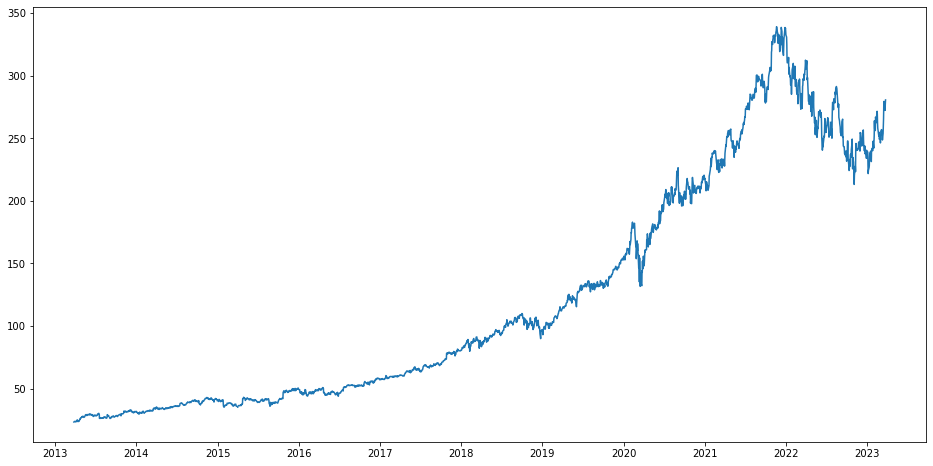

In [12]:
df["Date"]=pd.to_datetime(df.Date,format="%m/%d/%Y")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Adj Close"],label='Close Price history')

In [13]:
from sklearn.impute import KNNImputer

In [14]:
n_neighbors = 5

# create a k-NN imputer object
imputer = KNNImputer(n_neighbors=n_neighbors)

# loop over each column in the DataFrame
for column in df.columns:
    # get the column data as a numpy array
    column_data = df[column].values.reshape(-1, 1)
    
    # use k-NN imputation to fill in missing values
    imputer.fit(column_data)
    column_data_imputed = imputer.transform(column_data)
    
    # replace the original column with the imputed column
    df[column] = column_data_imputed.flatten()

print(df)

                    Date  Close/Last         Volume    Open    High     Low  \
Date                                                                          
2023-03-24  1.679616e+18      1983.8  276299.000000  1996.1  2006.5  1977.7   
2023-03-23  1.679530e+18      1995.9  257040.000000  1974.0  2006.1  1967.3   
2023-03-22  1.679443e+18      1949.6  240155.000000  1943.5  1982.3  1936.5   
2023-03-21  1.679357e+18      1941.1  242914.000000  1983.1  1988.7  1938.6   
2023-03-20  1.679270e+18      1999.7   66038.000000  2008.6  2031.7  1987.0   
...                  ...         ...            ...     ...     ...     ...   
2013-04-01  1.364774e+18      1600.9   57638.000000  1598.1  1601.6  1595.2   
2013-03-29  1.364515e+18      1595.7  183547.520526  1595.7  1595.7  1595.7   
2013-03-28  1.364429e+18      1595.7  105714.000000  1605.6  1608.3  1594.3   
2013-03-27  1.364342e+18      1607.2  152626.000000  1601.0  1609.0  1591.9   
2013-03-26  1.364256e+18      1597.3  125380.000000 

In [15]:
df.head()

,Date,Close/Last,Volume,Open,High,Low,Inflation,Adj Close,Unemployment
Date,,,,,,,,,
2023-03-24,1.679616e+18,1983.8,276299.0,1996.1,2006.5,1977.7,0.207287,280.57,5.206297
2023-03-23,1.679530e+18,1995.9,257040.0,1974.0,2006.1,1967.3,0.207287,277.66,5.206297
2023-03-22,1.679443e+18,1949.6,240155.0,1943.5,1982.3,1936.5,0.207287,272.29,5.206297
2023-03-21,1.679357e+18,1941.1,242914.0,1983.1,1988.7,1938.6,0.207287,273.78,5.206297
2023-03-20,1.679270e+18,1999.7,66038.0,2008.6,2031.7,1987.0,0.207287,272.23,5.206297


In [16]:
df.isnull().sum()

Date            0
Close/Last      0
Volume          0
Open            0
High            0
Low             0
Inflation       0
Adj Close       0
Unemployment    0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2543 entries, 2023-03-24 to 2013-03-26
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2543 non-null   float64
 1   Close/Last    2543 non-null   float64
 2   Volume        2543 non-null   float64
 3   Open          2543 non-null   float64
 4   High          2543 non-null   float64
 5   Low           2543 non-null   float64
 6   Inflation     2543 non-null   float64
 7   Adj Close     2543 non-null   float64
 8   Unemployment  2543 non-null   float64
dtypes: float64(9)
memory usage: 198.7 KB


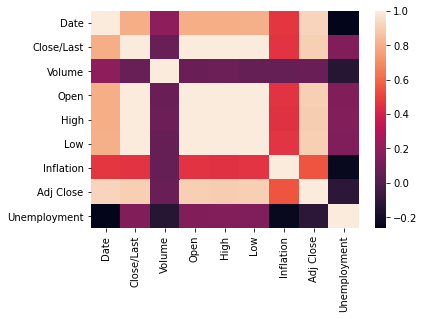

In [18]:
_ = sns.heatmap(df.corr())

In [19]:
Cleansed_df = df.drop(['Date', 'Volume', 'Open', 'High', 'Low', 'Unemployment'], axis=1)

In [20]:
Cleansed_df.rename(columns = {'Close/Last':'Gold Price', 'Inflation':'Inflation Rate', 'Adj Close':'MSFT Stock Price'}, inplace = True)

In [21]:
Cleansed_df.head()

,Gold Price,Inflation Rate,MSFT Stock Price
Date,,,
2023-03-24,1983.8,0.207287,280.57
2023-03-23,1995.9,0.207287,277.66
2023-03-22,1949.6,0.207287,272.29
2023-03-21,1941.1,0.207287,273.78
2023-03-20,1999.7,0.207287,272.23


In [22]:
Cleansed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2543 entries, 2023-03-24 to 2013-03-26
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gold Price        2543 non-null   float64
 1   Inflation Rate    2543 non-null   float64
 2   MSFT Stock Price  2543 non-null   float64
dtypes: float64(3)
memory usage: 79.5 KB


In [23]:
Cleansed_df.shape

(2543, 3)

We have 3 feature columns and one target column. The target column is 'Adj Close' and there are 2543 rows to the data frame.¶

EDA for the data set

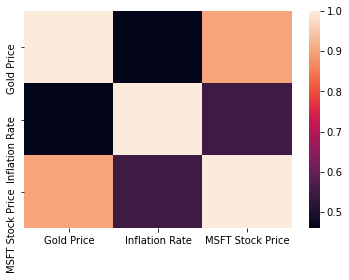

In [24]:
_ = sns.heatmap(Cleansed_df.corr())

In [25]:
# features creation by making it into a function

def create_features(Cleansed_df):
    """
    Create time series features based on time series index
    """
    Cleansed_df = Cleansed_df.copy()
    Cleansed_df['day of week'] = Cleansed_df.index.dayofweek
    Cleansed_df['quarter'] = Cleansed_df.index.quarter
    Cleansed_df['month'] = Cleansed_df.index.month
    Cleansed_df['year'] = Cleansed_df.index.year
    return Cleansed_df

Cleansed_df = create_features(Cleansed_df)

<AxesSubplot:xlabel='month', ylabel='MSFT Stock Price'>

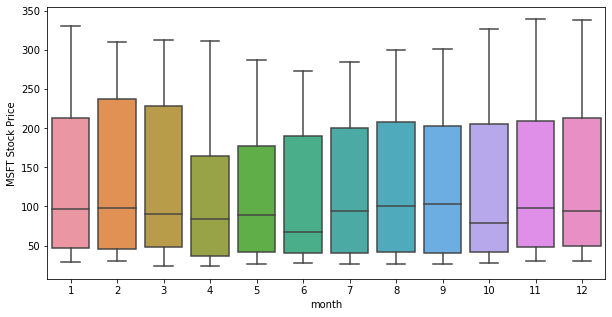

In [26]:
# We could vitualize our features

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=Cleansed_df, x='month', y='MSFT Stock Price')

<AxesSubplot:xlabel='quarter', ylabel='MSFT Stock Price'>

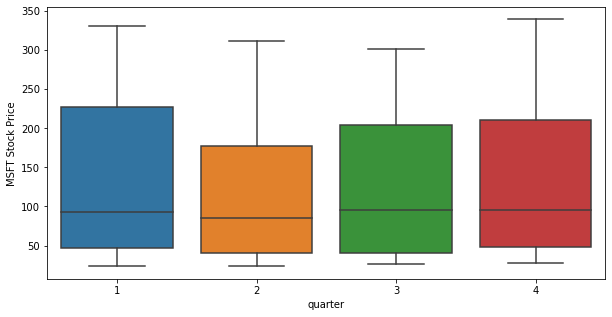

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=Cleansed_df, x='quarter', y='MSFT Stock Price')

<AxesSubplot:xlabel='year', ylabel='MSFT Stock Price'>

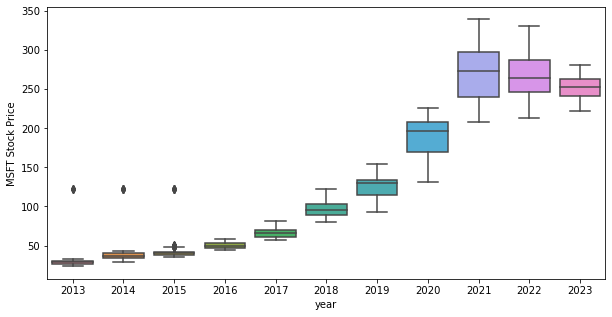

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=Cleansed_df, x='year', y='MSFT Stock Price')

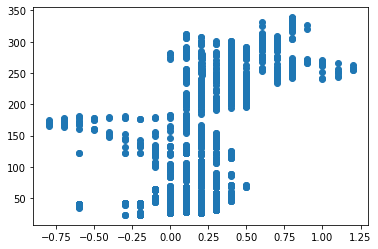

In [29]:
plt.scatter(Cleansed_df['Inflation Rate'],Cleansed_df['MSFT Stock Price'])

In [30]:
# select data within the specified date range
train = Cleansed_df.loc[Cleansed_df.index < '2021-03-01']
test = Cleansed_df.loc[Cleansed_df.index >= '2021-03-01']

In [31]:
# scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [32]:
train_scaled

array([[6.66012944e-01, 9.23076923e-01, 9.45374856e-01, ...,
        0.00000000e+00, 9.09090909e-02, 1.00000000e+00],
       [7.11708178e-01, 9.23076923e-01, 9.30011534e-01, ...,
        0.00000000e+00, 9.09090909e-02, 1.00000000e+00],
       [7.33771328e-01, 9.23076923e-01, 9.55201845e-01, ...,
        0.00000000e+00, 9.09090909e-02, 1.00000000e+00],
       ...,
       [5.35497156e-01, 3.84615385e-01, 1.75317186e-03, ...,
        0.00000000e+00, 1.81818182e-01, 0.00000000e+00],
       [5.46773877e-01, 3.84615385e-01, 8.30449827e-04, ...,
        0.00000000e+00, 1.81818182e-01, 0.00000000e+00],
       [5.37066091e-01, 3.84615385e-01, 0.00000000e+00, ...,
        0.00000000e+00, 1.81818182e-01, 0.00000000e+00]])

In [33]:
test_scaled

array([[0.91606197, 0.77483625, 1.1867128 , ..., 0.        , 0.18181818,
        1.25      ],
       [0.92792704, 0.77483625, 1.1732872 , ..., 0.        , 0.18181818,
        1.25      ],
       [0.88252599, 0.77483625, 1.14851211, ..., 0.        , 0.18181818,
        1.25      ],
       ...,
       [0.65326535, 1.        , 0.92355248, ..., 0.        , 0.18181818,
        1.        ],
       [0.67071975, 1.        , 0.95215686, ..., 0.        , 0.18181818,
        1.        ],
       [0.66032555, 1.        , 0.96604383, ..., 0.        , 0.18181818,
        1.        ]])

In [34]:
# Step 3: Reshape the data
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i+time_steps), :])
        y.append(dataset[i+time_steps, 0])
    return np.array(X), np.array(y)

# create the datasets
time_steps = 7
X_train, y_train = create_dataset(train_scaled, time_steps)
X_test, y_test = create_dataset(test_scaled, time_steps)

In [35]:
# Define train size
train_size = len(train)

In [37]:
import tensorflow as tf

In [38]:
# Step 4:

# Define the LSTM model with specified hyperparameters
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

# Define the optimizer with specified learning rate
lr = 0.001
optimizer = tf.keras.optimizers.Adam(lr=lr)

# Compile the model with the optimizer and loss function
model.compile(optimizer=optimizer, loss='mse')

# Train the model with the specified number of epochs and batch size
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/100
126/126 [==============================] - 3s 9ms/step - loss: 0.0092 - val_loss: 0.0031
Epoch 2/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 3/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 4/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 6/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0018 - val_loss: 9.6335e-04
Epoch 8/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 10/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0015 - va

Epoch 78/100
126/126 [==============================] - 1s 5ms/step - loss: 6.7414e-04 - val_loss: 5.6755e-04
Epoch 79/100
126/126 [==============================] - 1s 5ms/step - loss: 6.6693e-04 - val_loss: 0.0015
Epoch 80/100
126/126 [==============================] - 1s 5ms/step - loss: 7.5457e-04 - val_loss: 6.6175e-04
Epoch 81/100
126/126 [==============================] - 1s 5ms/step - loss: 8.2855e-04 - val_loss: 3.7196e-04
Epoch 82/100
126/126 [==============================] - 1s 5ms/step - loss: 6.5985e-04 - val_loss: 6.4122e-04
Epoch 83/100
126/126 [==============================] - 1s 5ms/step - loss: 7.0497e-04 - val_loss: 0.0011
Epoch 84/100
126/126 [==============================] - 1s 5ms/step - loss: 7.2007e-04 - val_loss: 7.3611e-04
Epoch 85/100
126/126 [==============================] - 1s 5ms/step - loss: 7.7774e-04 - val_loss: 3.9348e-04
Epoch 86/100
126/126 [==============================] - 1s 5ms/step - loss: 7.5644e-04 - val_loss: 4.7630e-04
Epoch 87/100
126/1

In [39]:
# Step 5: Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', train_loss)
print('Test loss:', test_loss)

Train loss: 0.000229820201639086
Test loss: 0.00048159071593545377


17/17 [==============================] - 0s 2ms/step


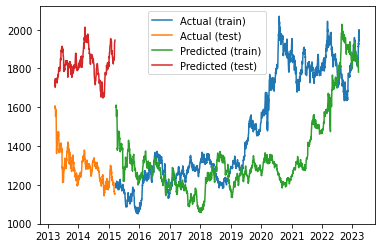

In [40]:
# Step 6: Make predictions and visualize the results
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_inverse = scaler.inverse_transform(np.concatenate((y_train_pred, X_train[:, -1, 1:]), axis=1))[:, 0]
y_test_pred_inverse = scaler.inverse_transform(np.concatenate((y_test_pred, X_test[:, -1, 1:]), axis=1))[:, 0]

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:], Cleansed_df.iloc[train_size+time_steps:, 0], label='Actual (test)')
plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')
plt.legend()
plt.show()

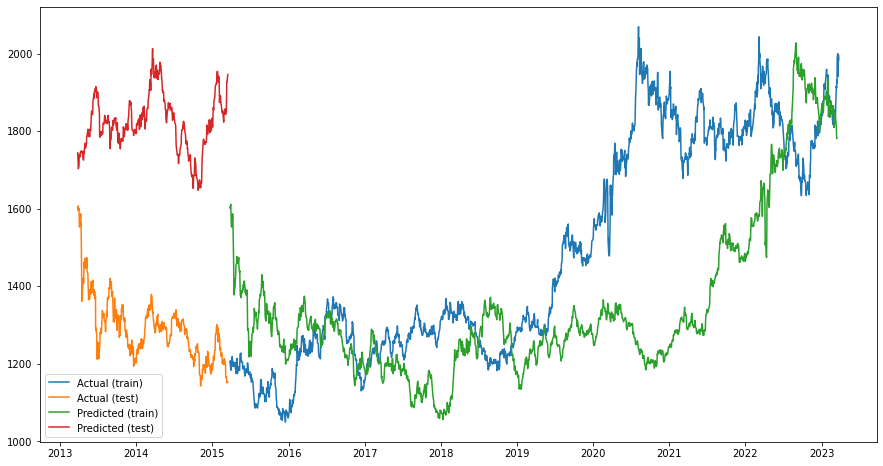

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
ax.plot(Cleansed_df.index[train_size+time_steps:], Cleansed_df.iloc[train_size+time_steps:, 0], label='Actual (test)')
ax.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
ax.plot(Cleansed_df.index[train_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')
ax.legend()
plt.show()

Epoch 1/50
403/403 [==============================] - 4s 6ms/step - loss: 0.0060 - val_loss: 0.0116
Epoch 2/50
403/403 [==============================] - 2s 4ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 3/50
403/403 [==============================] - 2s 4ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 4/50
403/403 [==============================] - 2s 4ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5/50
403/403 [==============================] - 2s 4ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 6/50
403/403 [==============================] - 2s 4ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 7/50
403/403 [==============================] - 2s 4ms/step - loss: 0.0015 - val_loss: 9.8507e-04
Epoch 8/50
403/403 [==============================] - 2s 4ms/step - loss: 0.0015 - val_loss: 0.0077
Epoch 9/50
403/403 [==============================] - 2s 4ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 10/50
403/403 [==============================] - 2s 4ms/step - loss: 0.0014 - val_loss: 0.

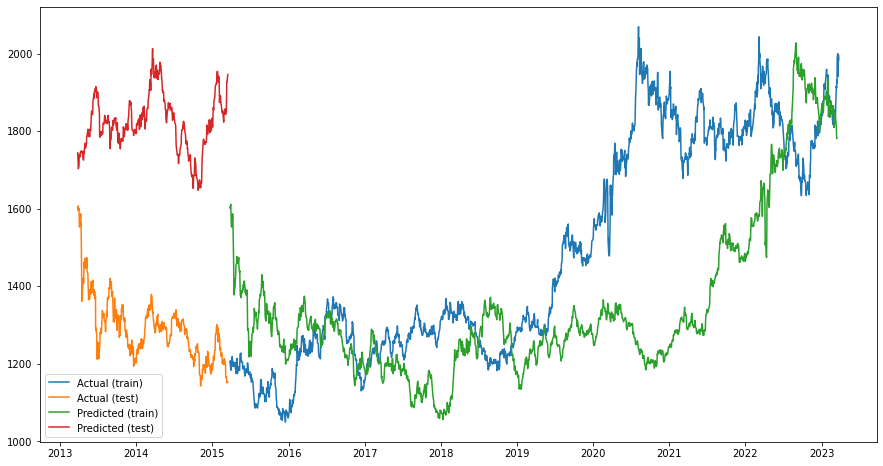

In [45]:
# Define the LSTM model with specified hyperparameters

K.clear_session()

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

# Define the optimizer with specified learning rate
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(lr=lr)

# Compile the model with the optimizer and loss function
model.compile(optimizer=optimizer, loss='mse')

# Train the model with the specified number of epochs and batch size
history = model.fit(X_train, y_train, epochs=50, batch_size=5, validation_data=(X_test, y_test), verbose=1)

# Step 5: Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', train_loss)
print('Test loss:', test_loss)


fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
ax.plot(Cleansed_df.index[train_size+time_steps:], Cleansed_df.iloc[train_size+time_steps:, 0], label='Actual (test)')
ax.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
ax.plot(Cleansed_df.index[train_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')
ax.legend()
plt.show()